In [1]:
import pandas_datareader as pdr
import pandas as pd
import datetime 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
dataset = pdr.get_data_yahoo('BANEP.ME', 
                          start=datetime.datetime(2015, 1, 1), 
                          end=datetime.datetime(2019, 12, 1))

In [3]:
dataset = dataset.reset_index()

In [4]:
dataset['Mean'] = (dataset['Low'] + dataset['High'])/2
dataset

,Date,High,Low,Open,Close,Volume,Adj Close,Mean
0,2015-01-05,94400.0,91500.0,92700.0,93500.0,16034.0,93004.703125,92950.0
1,2015-01-06,93800.0,92100.0,92800.0,92600.0,9201.0,92109.460938,92950.0
2,2015-01-08,96500.0,92500.0,92700.0,95600.0,74265.0,95093.578125,94500.0
3,2015-01-09,96700.0,92500.0,95600.0,93800.0,47926.0,93303.109375,94600.0
4,2015-01-12,94200.0,92200.0,93400.0,93400.0,21278.0,92905.218750,93200.0
...,...,...,...,...,...,...,...,...
1230,2019-11-25,175000.0,173600.0,174000.0,174800.0,27464.0,174800.000000,174300.0
1231,2019-11-26,175800.0,173500.0,174500.0,173600.0,19564.0,173600.000000,174650.0
1232,2019-11-27,174550.0,173100.0,174100.0,173750.0,13749.0,173750.000000,173825.0
1233,2019-11-28,174050.0,172050.0,173750.0,173000.0,21353.0,173000.000000,173050.0


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 8 columns):
Date         1235 non-null datetime64[ns]
High         1235 non-null float64
Low          1235 non-null float64
Open         1235 non-null float64
Close        1235 non-null float64
Volume       1235 non-null float64
Adj Close    1235 non-null float64
Mean         1235 non-null float64
dtypes: datetime64[ns](1), float64(7)
memory usage: 77.3 KB


In [6]:
steps=-1
dataset_for_prediction= dataset.copy()
dataset_for_prediction['Actual']=dataset_for_prediction['Mean'].shift(steps)
dataset_for_prediction.head(3)

,Date,High,Low,Open,Close,Volume,Adj Close,Mean,Actual
0,2015-01-05,94400.0,91500.0,92700.0,93500.0,16034.0,93004.703125,92950.0,92950.0
1,2015-01-06,93800.0,92100.0,92800.0,92600.0,9201.0,92109.460938,92950.0,94500.0
2,2015-01-08,96500.0,92500.0,92700.0,95600.0,74265.0,95093.578125,94500.0,94600.0


In [7]:
dataset_for_prediction=dataset_for_prediction.dropna()

Text(0.5, 1.0, 'BASHNEFT Stock Value')

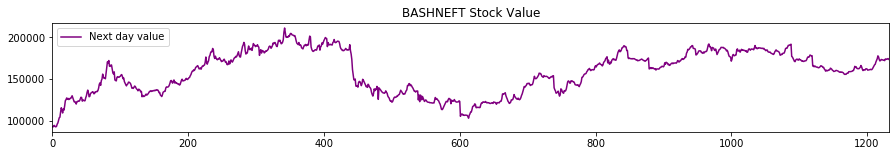

In [8]:
dataset_for_prediction['Mean'].plot(color='purple', figsize=(15,2))
plt.legend(['Next day value', 'Mean'])
plt.title("BASHNEFT Stock Value")

Text(0.5, 1.0, 'BASHNEFT Stock Volume')

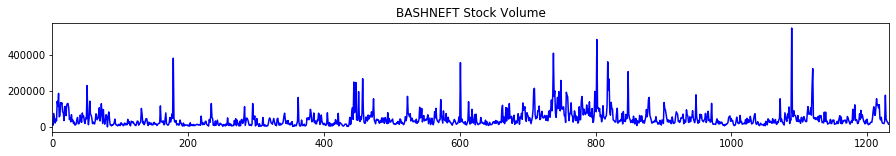

In [9]:
dataset_for_prediction['Volume'].plot(color='blue', figsize=(15,2))
plt.title("BASHNEFT Stock Volume")

In [10]:
from sklearn.preprocessing import MinMaxScaler
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset_for_prediction[['Low', 'High','Open', 'Close', 'Volume', 'Adj Close', 'Mean']])
scaled_input =pd.DataFrame(scaled_input)
X= scaled_input

In [11]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_for_prediction[['Actual']])
scaler_output =pd.DataFrame(scaler_output)
y=scaler_output

In [12]:
X.rename(columns={0:'Low', 1:'High', 2:'Open', 3:'Close', 4:'Volume', 5:'Adj Close', 6:'Mean'}, inplace=True)
X.head(2)

,Low,High,Open,Close,Volume,Adj Close,Mean
0,0.000000,0.004898,0.000000,0.007637,0.029284,0.007614,0.0
1,0.005236,0.000000,0.000849,0.000000,0.016805,0.000000,0.0


In [13]:
y.rename(columns={0:'Stock Price next day'}, inplace= True)
y.index=dataset_for_prediction.index
y.head(2)

,Stock Price next day
0,0.000000
1,0.013108


In [14]:
train_size=int(len(dataset) *0.7)
test_size = int(len(dataset)) - train_size
train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

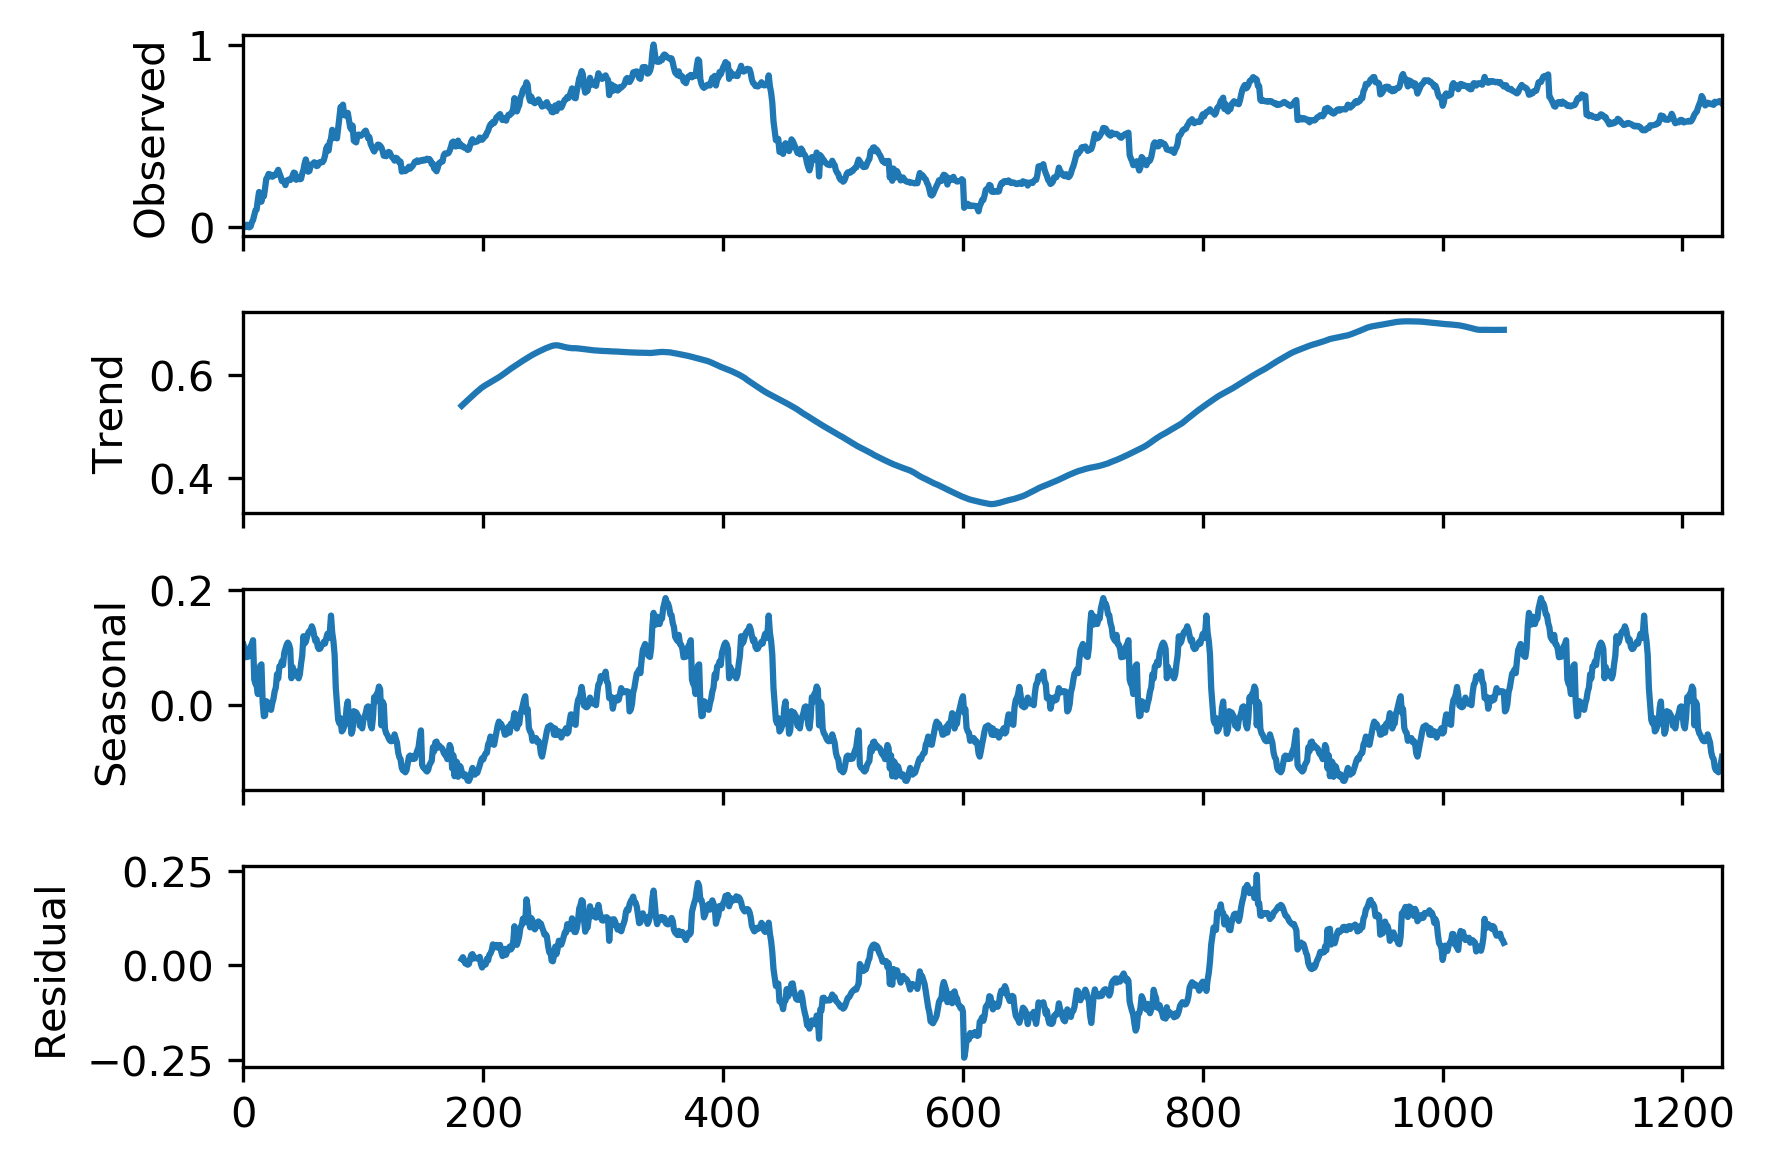

In [15]:
import statsmodels.api as sm
seas_d=sm.tsa.seasonal_decompose(X['Mean'],model='add',freq=365);
fig=seas_d.plot()
fig.set_figheight(4)
fig.dpi=300
plt.show()

In [16]:
from statsmodels.tsa.stattools import adfuller
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [17]:
y_test=y['Stock Price next day'][:train_size].dropna()
test_adf(y_test, "Stock Price")

Strong evidence for  Null Hypothesis
Accept Null Hypothesis - Data is not Stationary
Data is NOT Stationary for Stock Price


In [18]:
test_adf(y_test.diff(), "Stock Price")

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary Stock Price


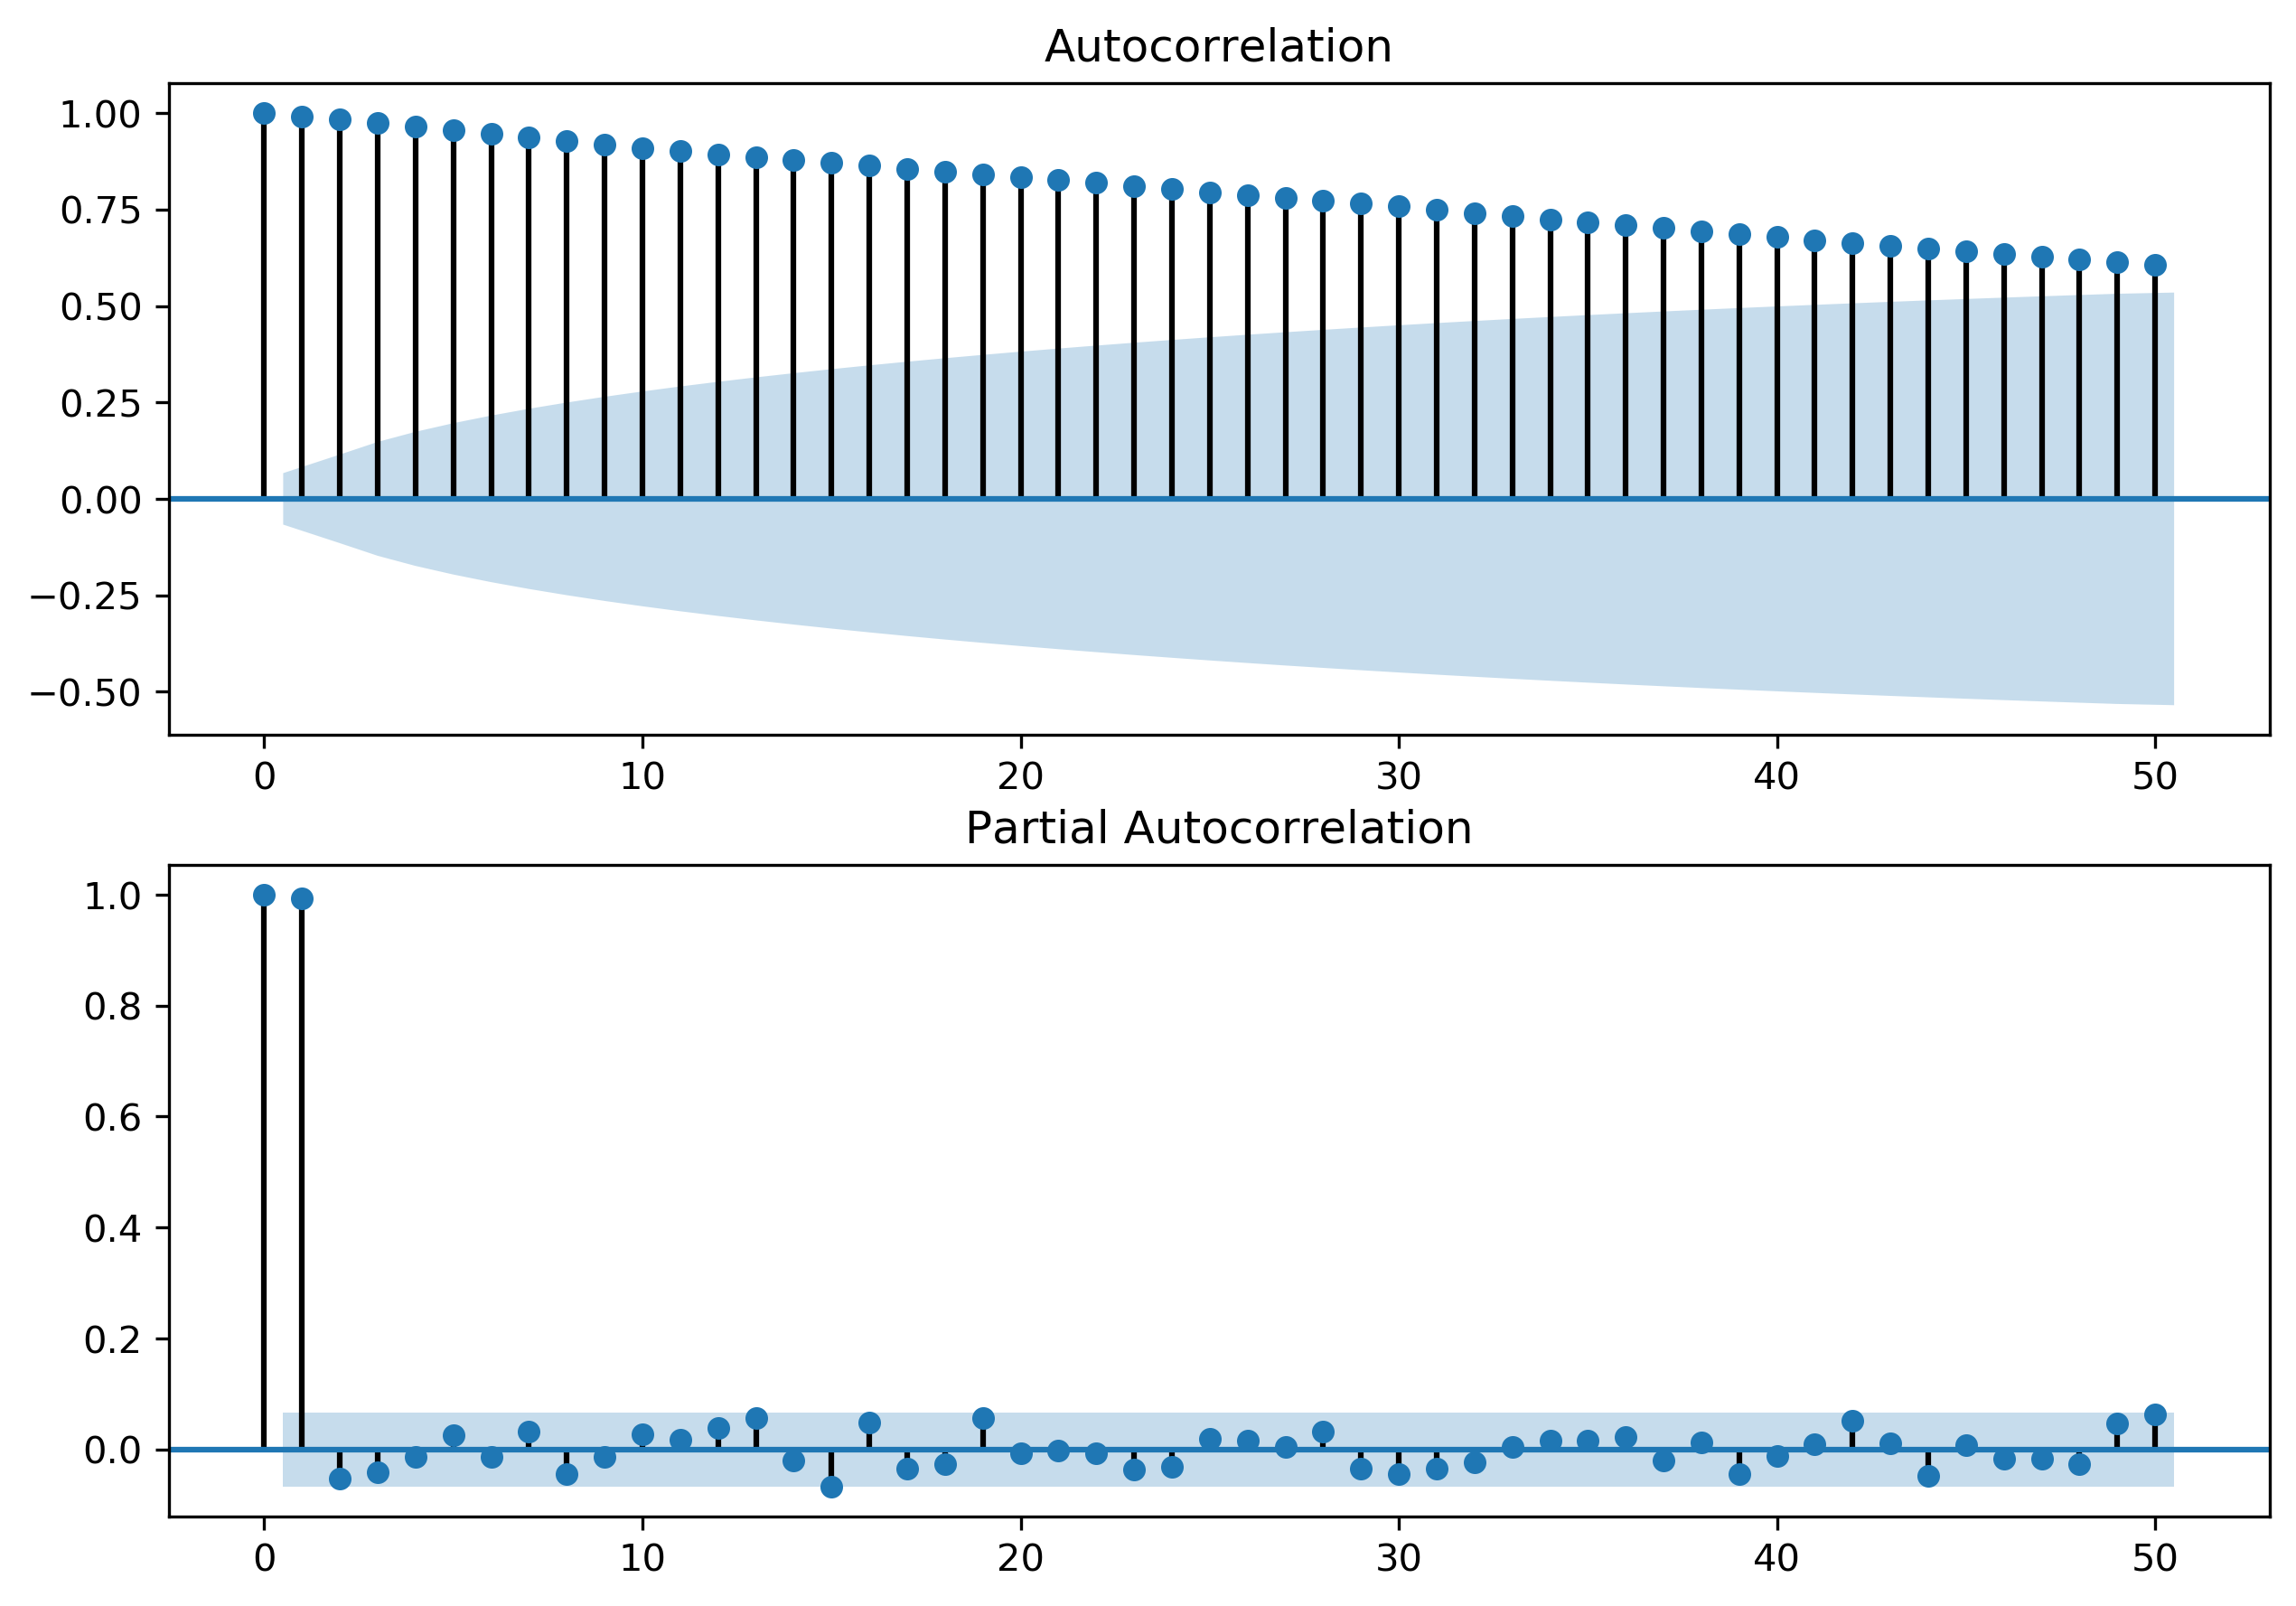

In [19]:
fig,ax= plt.subplots(2,1, figsize=(10,7), dpi=300)
fig=sm.tsa.graphics.plot_acf(y_test, lags=50, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_test, lags=50, ax=ax[1])
plt.show()

In [20]:
from pmdarima.arima import auto_arima
step_wise=auto_arima(train_y, 
 exogenous= train_X,
 start_p=1, start_q=1, 
 max_p=7, max_q=7, 
 d=1, max_d=7,
 trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-4470.110, BIC=-4417.746, Fit time=1.148 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-4393.873, BIC=-4351.029, Fit time=0.197 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-4431.817, BIC=-4384.213, Fit time=0.752 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-4514.550, BIC=-4466.946, Fit time=1.169 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-4517.407, BIC=-4465.042, Fit time=1.407 seconds
Fit ARIMA: order=(1, 1, 3) seasonal_order=(0, 0, 0, 1); AIC=-4491.113, BIC=-4429.227, Fit time=1.766 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-4497.075, BIC=-4439.950, Fit time=1.552 seconds
Fit ARIMA: order=(0, 1, 3) seasonal_order=(0, 0, 0, 1); AIC=-4515.431, BIC=-4458.306, Fit time=1.816 seconds
Total fit time: 9.810 seconds


In [21]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  864
Model:               SARIMAX(0, 1, 2)   Log Likelihood                2269.703
Date:                Tue, 12 May 2020   AIC                          -4517.407
Time:                        22:06:50   BIC                          -4465.042
Sample:                             0   HQIC                         -4497.363
                                - 864                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.329e-05    4.3e-05      0.775      0.439   -5.09e-05       0.000
x1            -0.0686      0.038     -1.783      0.075      -0.144       0.007
x2             0.0603      0.049      1.229      0.219      -0.036       0.157
x3            -0.0152      0.067     -0.227      0.820      -0.146       0.116
x4             5.4186      2.418      2.241      0.025       0.679      10.158
x5            -0.0235      0.005     -5.222      0.000      -0.032      -0.015
x6            -4.4319      2.420     -1.831      0.067      -9.175       0.311
x7            -0.0019      0.032     -0.060      0.952      -0.064       0.060
ma.L1         -0.9096      0.058    -15.552      0.000      -1.024      -0.795
ma.L2         -0.0369      0.056     -0.654      0.513      -0.147       0.074
sigma2         0.0003   6.51e-06     46.491      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       30.41   Jarque-Bera (JB):              7674.51
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                            -2.00
Prob(H) (two-sided):                  0.13   Kurtosis:                        17.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.45e+18. Standard errors may be unstable.
"""

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(train_y, 
 exog=train_X,
 order=(0,1,2),
 enforce_invertibility=False, enforce_stationarity=False)

c:\users\emilo\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [23]:
results = model.fit()

In [24]:
predictions= results.predict(start =train_size, end=train_size+test_size+(steps)-1,exog=test_X)

ValueError: Provided exogenous values are not of the appropriate shape. Required (864, 7), got (370, 7).

In [ ]:
forecast_1= results.forecast(steps=test_size-1, exog=test_X)

In [ ]:
act= pd.DataFrame(scaler_output.iloc[train_size:, 0])

In [ ]:
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['Stock Price next day']
predictions.rename(columns={0:'Pred'}, inplace=True)

In [ ]:
predictions['Actual'].plot(figsize=(20,8), legend=True, color='purple')
predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))
fig.dpi=300

In [ ]:
forecast_tatn= pd.DataFrame(forecast_1)
forecast_tatn.reset_index(drop=True, inplace=True)
forecast_tatn.index=test_X.index
forecast_tatn['Actual'] =scaler_output.iloc[train_size:, 0]
forecast_tatn.rename(columns={0:'Forecast'}, inplace=True)

In [ ]:
forecast_tatn['Forecast'].plot(legend=True)
forecast_tatn['Actual'].plot(legend=True)

In [ ]:
from statsmodels.tools.eval_measures import rmse
error=rmse(predictions['Pred'], predictions['Actual'])
error

In [98]:
trainPredict = sc_out.inverse_transform(predictions[['Pred']])
testPredict = sc_out.inverse_transform(predictions[['Actual']])